In [1]:
from scipy.integrate import cumulative_trapezoid
import scipy.optimize as optim

from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
import numpy as np
import matplotlib.pyplot as plt
import siunits as unit

In [41]:
def make_simple_plot(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    plt.xlim([0, 10])
    plt.ylim([-20, 40])
    ax.grid()
    plt.show()
    return fig, ax

In [3]:
np.triu([[1,2], [3,4]], k=-1)

array([[1, 2],
       [3, 4]])

In [4]:
np.triu_indices(1, 1)

(array([], dtype=int64), array([], dtype=int64))

In [5]:
a = np.arange(1, 5).reshape(2, 2)

In [6]:
a

array([[1, 2],
       [3, 4]])

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [7]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [8]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [9]:
unit.c

coulomb (C), [s: 1, A: 1]

In [10]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [11]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [12]:
Avogadro

6.02214076e+23

### Liquid (model) parameters

Page 62

In [13]:
valence = np.array([1.0, -1.0])    # KCl: 1-1 electrolyte
temperature = 1075.0               # 1075 K
concentration = 19.265             # mol dm^{-3}

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [14]:
def calc_rho(concentration):
    return np.array([concentration, concentration]) / 1.0e27 * Avogadro

In [15]:
rho = calc_rho(concentration)

In [16]:
rho   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [17]:
def calc_charge(valence):
    return valence * elementary_charge

In [18]:
charge = calc_charge(valence)

In [19]:
charge  # units are C

array([ 1.60217663e-19, -1.60217663e-19])

In [20]:
epsilon = 4.0 * np.pi * epsilon_0   # units same as $\epsilon_0$

In [21]:
epsilon

1.1126500554478704e-10

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [22]:
beta = 1.0 / (Boltzmann * temperature)

In [23]:
beta

6.737646991665042e+19

$\beta^{-1} = k T$. Units: $\rm m^{2} \cdot kg \cdot s^{-2}$

In [24]:
beta_inv = Boltzmann * temperature

In [25]:
beta_inv

1.484197675e-20

In [27]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [28]:
kappa = calc_kappa(beta, rho, epsilon)

In [38]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Discretisation of functions

In [40]:
z_cutoff = 50.0
npoint = 2001
grid_size = z_cutoff / (npoint - 1) 
z = np.linspace(0.0, z_cutoff, npoint)

print(grid_size)

0.025


### Wall-ion potential

In [32]:
psi_0 = 0     # 0 mV

In [33]:
capital_a = 16.274e-19 # joules
wall_d = 2.97  # inverse Angstrom

In [34]:
# same for both ions

def wall_ion_potential(z):
    return np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)


In [35]:
phi = wall_ion_potential(z)

In [36]:
beta_phi = beta * phi 

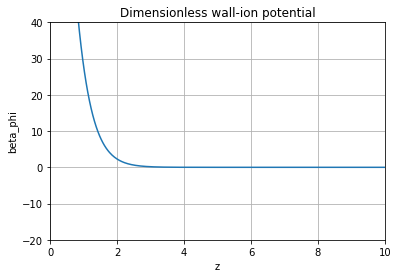

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Dimensionless wall-ion potential'}, xlabel='z', ylabel='beta_phi'>)

In [42]:
make_simple_plot(z, beta_phi, "z", "beta_phi", "Dimensionless wall-ion potential")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [ ]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

f1z = np.zeros(npoint, dtype=np.float64)
f2z = np.zeros(npoint, dtype=np.float64)

### Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [ ]:
tz_initial_guess = np.zeros(npoint, dtype=np.float64)    # initial guess of zero - t(z) = ln g(z) + beta phi(z)

In [ ]:
def hz(z):
    return np.exp(z) / np.exp(beta_phi) - 1.0

def fabs(z, t):
    return f1z(abs(z - t))


In [ ]:
# TODO: Need to arrange so t(z) is subject

def singlet_equation_tz(rho, f1z, f2z, hz, z):
    int_z_inf = cumulative_trapezoid(y=hz, x=z)
    int_0_z = cumulative_trapezoid(y=z*hz, x=z)
    int_0_inf = cumulative_trapezoid(y=hz*fabs(z, t), x=z)
    tz = -psi_0 * charge * beta + 2 * np.pi * (rho * z * f1z - f2z + 2 * charge * charge / epsilon * int_z_inf + z * int_0_z)
    + int_0_inf
    return tz


### Numerical integration

Extended trapezoidal rule

In [ ]:
int_wall_potential = cumulative_trapezoid(y=beta_phi, x=z)

In [ ]:
int_wall_potential

array([  5.38074599,  10.55865192,  15.53519421, ..., 110.77299022,
       110.77299022, 110.77299022])

In [ ]:
def func_opt(tz):
    pass

In [ ]:
tolerance = 1e-9

In [ ]:
solution = optim.root(func_opt, tz_initial_guess, args=(), method="krylov", jac=None, tol=tolerance, callback=None, options=None)

ValueError: array must not contain infs or NaNs

In [ ]:
tz_solution = solution.x

NameError: name 'solution' is not defined